In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time

In [2]:
%matplotlib inline

In [3]:
import requests
from bs4 import BeautifulSoup
from astropy.table import Table

# # URL of the webpage
# url = "https://www.wiserep.org/search/spectra?&name=&name_like=0&public=all&inserted_period_value=0&inserted_period_units=days&type%5B%5D=null&type_family%5B%5D=null&instruments%5B%5D=null&spectypes%5B%5D=10&qualityid%5B%5D=null&groupid%5B%5D=null&spectra_count=&redshift_min=&redshift_max=&obsdate_start%5Bdate%5D=&obsdate_end%5Bdate%5D=&spec_phase_min=&spec_phase_max=&spec_phase_unit=days&phase_types%5B%5D=null&filters%5B%5D=null&methods%5B%5D=null&wl_min=&wl_max=&obj_ids=&spec_ids=&ids_or=0&reporters=&publish=2022A%26A...659A..34C&contrib=&last_modified_start%5Bdate%5D=&last_modified_end%5Bdate%5D=&last_modified_modifier=&creation_start%5Bdate%5D=&creation_end%5Bdate%5D=&creation_modifier=&show_aggregated_spectra=1&show_all_spectra=0&table_phase_name=40&num_page=250&display%5Bobj_rep_internal_name%5D=1&display%5Bobj_type_family_name%5D=0&display%5Bobj_type_name%5D=1&display%5Bredshift%5D=1&display%5Bphases%5D=1&display%5Bexptime%5D=1&display%5Bobserver%5D=1&display%5Breducers%5D=1&display%5Bsource_group_name%5D=1&display%5Basciifile%5D=1&display%5Bfitsfile%5D=1&display%5Bspectype_name%5D=1&display%5Bquality_name%5D=1&display%5Bextinction_corr_name%5D=0&display%5Bflux_calib_name%5D=0&display%5Bwl_medium_name%5D=0&display%5Bgroups%5D=0&display%5Bpublic%5D=1&display%5Bend_pop_period%5D=0&display%5Breporters%5D=0&display%5Bpublish%5D=1&display%5Bcontrib%5D=0&display%5Bremarks%5D=0&display%5Bcreatedby%5D=1&display%5Bcreationdate%5D=1&display%5Bmodifiedby%5D=0&display%5Blastmodified%5D=0"
#
# # Send a request to the webpage
# response = requests.get(url)

with open("/Users/nmearl/Downloads/Spectra search WISeREP.html", "r") as f:
    html = f.read()

soup = BeautifulSoup(html, 'html.parser')

# Find the table with class "results-table main-results-table"
table = soup.find('table', class_='results-table main-results-table')

# Extract table headers
headers = [th.text.strip() for th in table.find('thead').find_all('th')]

# Extract table rows
rows = []
for tr in table.find('tbody').find_all('tr'):
    cells = [str(td.text.strip()) for td in tr.find_all('td')]
    rows.append(cells)


In [4]:
html_dict = {header: [] for header in headers}

for row in rows:
    for i, header in enumerate(headers):
        if len(row) != len(headers):
            continue
        html_dict[header].append(row[i])

# Convert to Astropy table
astropy_table = Table(html_dict)

In [5]:
from pathlib import Path

raw_dir = Path("/Users/nmearl/research/tde_agn_comparison/raw")
parsed_dir = Path("/Users/nmearl/research/tde_agn_comparison/parsed")
dl_path = "https://www.wiserep.org/system/files/uploaded/general/"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"
}

iau_names = np.array(astropy_table["Obj. IAU Name"].data)
alt_names = np.array(astropy_table["Obj. Alt. Name/s"].data)
iau_names[iau_names == ""] = alt_names[iau_names == ""]
astropy_table["full_name"] = iau_names

for name in set(astropy_table["full_name"]):
    sub_tab = astropy_table[astropy_table["full_name"] == name]
    pname = str(name.replace(" ", ""))

    for dtime in set(sub_tab["Obs-date (UT)"]):
        rows = sub_tab[sub_tab["Obs-date (UT)"] == dtime]
        rows['Obj. IAU Name', 'Spectrum ascii File', 'Redshift'].pprint_all()

        file_names = [row["Spectrum ascii File"] for row in rows]
        inst = [row["Tel / Inst"] for row in rows]

        assert len(set(inst)) == 1

        if len(file_names) == 3:
            raw_file_name = next((f for f in file_names if f.endswith("None.txt")), None)
            red_file_name = next((f for f in file_names if f.endswith("_1.txt")), None)
        elif len(file_names) == 2:
            raw_file_name = next((f for f in file_names if f.endswith("_0.txt")), None)
            red_file_name = next((f for f in file_names if f.endswith("None.txt")), None)

        # Parse the raw data to get uncertainty estimate
        response = requests.get(dl_path + raw_file_name, headers=headers)

        with open(raw_dir / f"{name}_raw.txt", 'wb') as file:
            file.write(response.content)

        uncs_given = False
        raw_tab = Table.read(raw_dir / f"{name}_raw.txt", format="ascii")

        if len(raw_tab.colnames) == 2:
            unc_colname = 'col2'
        elif len(raw_tab.colnames) == 3:
            uncs_given = True
            unc_colname = 'col3'
        elif len(raw_tab.colnames) == 7:
            uncs_given = True
            unc_colname = 'col4'
        elif len(raw_tab.colnames) == 4:
            uncs_given = True
            unc_colname = 'col3'

        # Parse the reduced data
        response = requests.get(dl_path + red_file_name, headers=headers)

        with open(raw_dir / f"{name}_reduced.txt", 'wb') as file:
            file.write(response.content)

        red_tab = Table.read(raw_dir / f"{name}_reduced.txt", format="ascii", names=["wave", "flux"])

        # Interpolate and calculate uncertainties
        if uncs_given:
            uncertainties = np.interp(red_tab["wave"], raw_tab["col1"], raw_tab[unc_colname])
        else:
            uncertainties = np.interp(red_tab["wave"], raw_tab["col1"], raw_tab[unc_colname]) * 0.1

        # Add uncertainties to the reduced table
        obs_date = Time(dtime).mjd

        red_tab["uncertainty"] = uncertainties
        red_tab.meta["name"] = str(name)
        red_tab.meta["redshift"] = float(rows[0]["Redshift"])
        red_tab.meta["obs_date"] = obs_date
        red_tab.meta['telescope'] = str(inst[0].split("/")[0].strip())
        red_tab.meta['instrument'] = str(inst[0].split("/")[1].strip())

        # Save the table
        red_tab.write(parsed_dir / f"{pname}_{obs_date}.ecsv", format="ascii.ecsv", overwrite=True)

Obj. IAU Name                Spectrum ascii File                Redshift
------------- ------------------------------------------------- --------
  TDE 2018fyk   AT2018fyk_2458423.5_ESO-NTT_EFOSC2-NTT_None.txt     0.06
  TDE 2018fyk AT2018fyk_2458423.5_ESO-NTT_EFOSC2-NTT_None_0.txt     0.06
  TDE 2018fyk AT2018fyk_2458423.5_ESO-NTT_EFOSC2-NTT_None_1.txt     0.06
Obj. IAU Name                Spectrum ascii File                Redshift
------------- ------------------------------------------------- --------
  TDE 2018fyk   AT2018fyk_2458394.5_ESO-NTT_EFOSC2-NTT_None.txt     0.06
  TDE 2018fyk AT2018fyk_2458394.5_ESO-NTT_EFOSC2-NTT_None_0.txt     0.06
  TDE 2018fyk AT2018fyk_2458394.5_ESO-NTT_EFOSC2-NTT_None_1.txt     0.06
Obj. IAU Name                Spectrum ascii File                Redshift
------------- ------------------------------------------------- --------
  TDE 2018fyk   AT2018fyk_2458409.5_ESO-NTT_EFOSC2-NTT_None.txt     0.06
  TDE 2018fyk AT2018fyk_2458409.5_ESO-NTT_EFOSC2-NT

In [ ]:
test_tab = Table.read("/Users/nmearl/research/tde_agn_comparison/raw/ASASSN-14li_reduced.txt", format="ascii")
test_raw_tab = Table.read("/Users/nmearl/research/tde_agn_comparison/raw/ASASSN-14li_raw.txt", format="ascii")

In [ ]:
fig, ax = plt.subplots()

ax.plot(test_tab["col1"], test_tab["col2"])
ax.plot(test_tab["col1"], test_tab["col3"])
ax.plot(test_tab["col1"], test_tab["col4"])

ax.errorbar(test_tab["col1"], test_tab["col3"], yerr=test_tab["col2"], fmt="o")

In [ ]:
hyz_tab_raw = Table.read("/Users/nmearl/Downloads/AT2018hyz_2458539.5_ESO-NTT_EFOSC2-NTT_None.txt", format="ascii")
hyz_tab_red = Table.read("/Users/nmearl/Downloads/AT2018hyz_2458539.5_ESO-NTT_EFOSC2-NTT_None_0.txt", format="ascii")

In [ ]:
fig, ax = plt.subplots()

ax.plot(hyz_tab_raw["col1"], hyz_tab_raw["col2"])
ax.plot(hyz_tab_red["col1"], hyz_tab_red["col2"])

In [ ]:
zr_tab_raw = Table.read("/Users/nmearl/Downloads/AT2018zr_2458202.5_Magellan-Baade_IMACS_None.txt", format="ascii")
zr_tab_red1 = Table.read("/Users/nmearl/Downloads/AT2018zr_2458202.5_Magellan-Baade_IMACS_None_0.txt", format="ascii")
zr_tab_red2 = Table.read("/Users/nmearl/Downloads/AT2018zr_2458202.5_Magellan-Baade_IMACS_None_1.txt", format="ascii")

In [ ]:
fig, ax = plt.subplots()

ax.plot(zr_tab_raw["col1"], zr_tab_raw["col2"])
ax.plot(zr_tab_red1["col1"], zr_tab_red1["col2"])
ax.plot(zr_tab_red2["col1"], zr_tab_red2["col2"])

In [ ]:
ae_tab_raw = Table.read("/Users/nmearl/Downloads/ASASSN-14ae_2456755.5_APO-3.5m_DIS_None.txt", format="ascii")
ae_tab_red = Table.read("/Users/nmearl/Downloads/ASASSN-14ae_2456755.5_APO-3.5m_DIS_None_0.txt", format="ascii")

In [ ]:
fig, ax = plt.subplots()

ax.plot(ae_tab_raw["col1"], ae_tab_raw["col2"])
ax.plot(ae_tab_red["col1"], ae_tab_red["col2"])

In [ ]:
oi_tab_raw = Table.read("/Users/nmearl/Downloads/ASASSN-15oi_2457273.5_ESO-NTT_EFOSC2-NTT_None.txt", format="ascii")
oi_tab_red1 = Table.read("/Users/nmearl/Downloads/ASASSN-15oi_2457273.5_ESO-NTT_EFOSC2-NTT_None_0.txt", format="ascii")
oi_tab_red2 = Table.read("/Users/nmearl/Downloads/ASASSN-15oi_2457273.5_ESO-NTT_EFOSC2-NTT_None_1.txt", format="ascii")

In [ ]:
fig, ax = plt.subplots()

ax.plot(oi_tab_raw["col1"], oi_tab_raw["col2"])
ax.plot(oi_tab_red1["col1"], oi_tab_red1["col2"])
ax.plot(oi_tab_red2["col1"] * (1 - 0.0484), oi_tab_red2["col2"])

ax.axvline(6563, color="k", linestyle="--")
ax.axhline(0, color="k", linestyle="--")

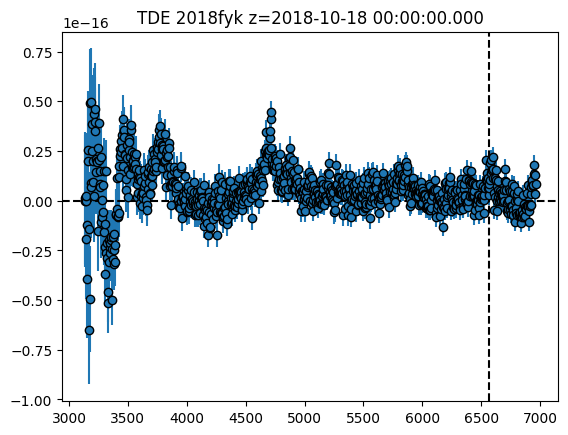

In [16]:
for file_path in Path("/Users/nmearl/research/tde_agn_comparison/parsed").rglob("*.ecsv"):
    tab = Table.read(file_path, format="ascii.ecsv")
    name = tab.meta['name']
    redshift = tab.meta['redshift']
    utc_time = Time(tab.meta['obs_date'], format="mjd").iso

    fig, ax = plt.subplots()
    ax.errorbar(tab["wave"] / (1 + redshift), tab["flux"], yerr=tab["uncertainty"], fmt="o", markeredgecolor="k")
    ax.axvline(6563, color="k", linestyle="--")
    ax.axhline(0, color="k", linestyle="--")
    ax.set_title(name + f" z={utc_time}")

    break